# Franceschin CERIC beamtime @ SYRMEP Elettra
## Image processing of corroded pit

[pearls sphericity](100slices_sphericity.png)

#### - The following steps are already performed in the notebook [perline](perline.ipynb)

1. Segment and create masks of pit region and pearls
2. Study size and sphericity of pearls

#### - In this notebook we use the `label toolkit` of the [spam](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html) package to:

3. Label single pearls
4. Analyse pearls size, sphericity and orientation

For a complete explanation of the particle metrics analyzed in this notebook see the complete spam example [plot_labelToolkit01](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html)

Created on:  26.04.2022 <br />
Last update: 04.05.2022 <br />

In [1]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

## Configuration

In [1]:
import sys
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

In [2]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage # , misc
# from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
# from pybonemorph import remove_unconnected, remove_largest

import spam.mesh
import spam.label
import spam.plotting
import spam.datasets

astropy module not found
olefile module not found
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

## 0. Load input data
loading small portion (100 slices) of the full dataset..

In [3]:
# input_file = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/slices/slice_0000.tif'
input_file = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/100slices/slice_4101.tif'

In [4]:
data_3D = read_tiff_stack(input_file, [4100, 4199])

In [5]:
vs = np.ones(3)*1.0e-3 # [mm]

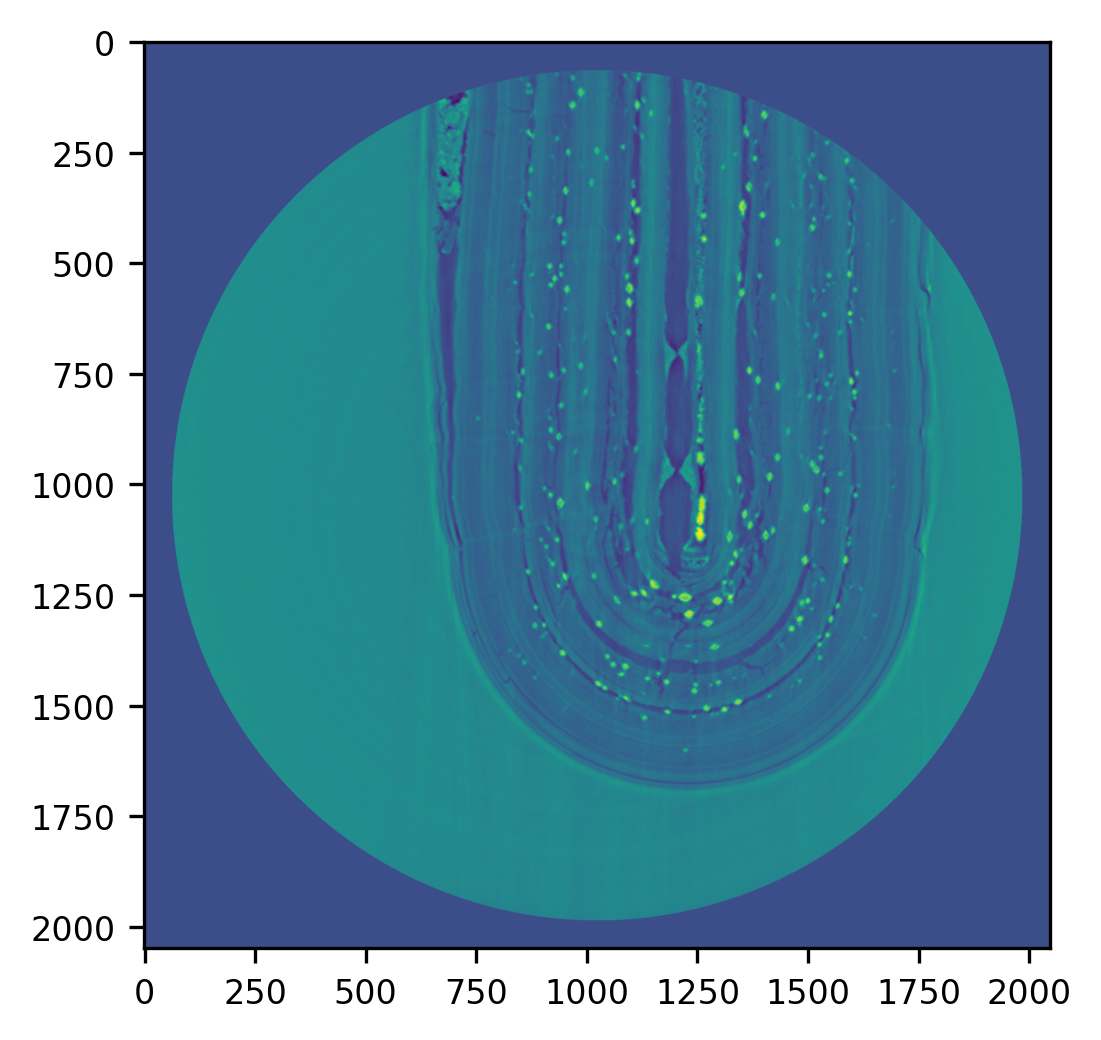

In [7]:
# Inspect slice
plt.imshow(data_3D[20,:,:])

#### Load pearls mask
The mask was obtained in the notebook [perline](perline.ipynb)

In [4]:
mask_file = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_pearls/slice_00000.tif'

In [7]:
BW_pearls = read_tiff_stack(mask_file)

In [8]:
vs = np.ones(3)*1.0e-3 # [mm]

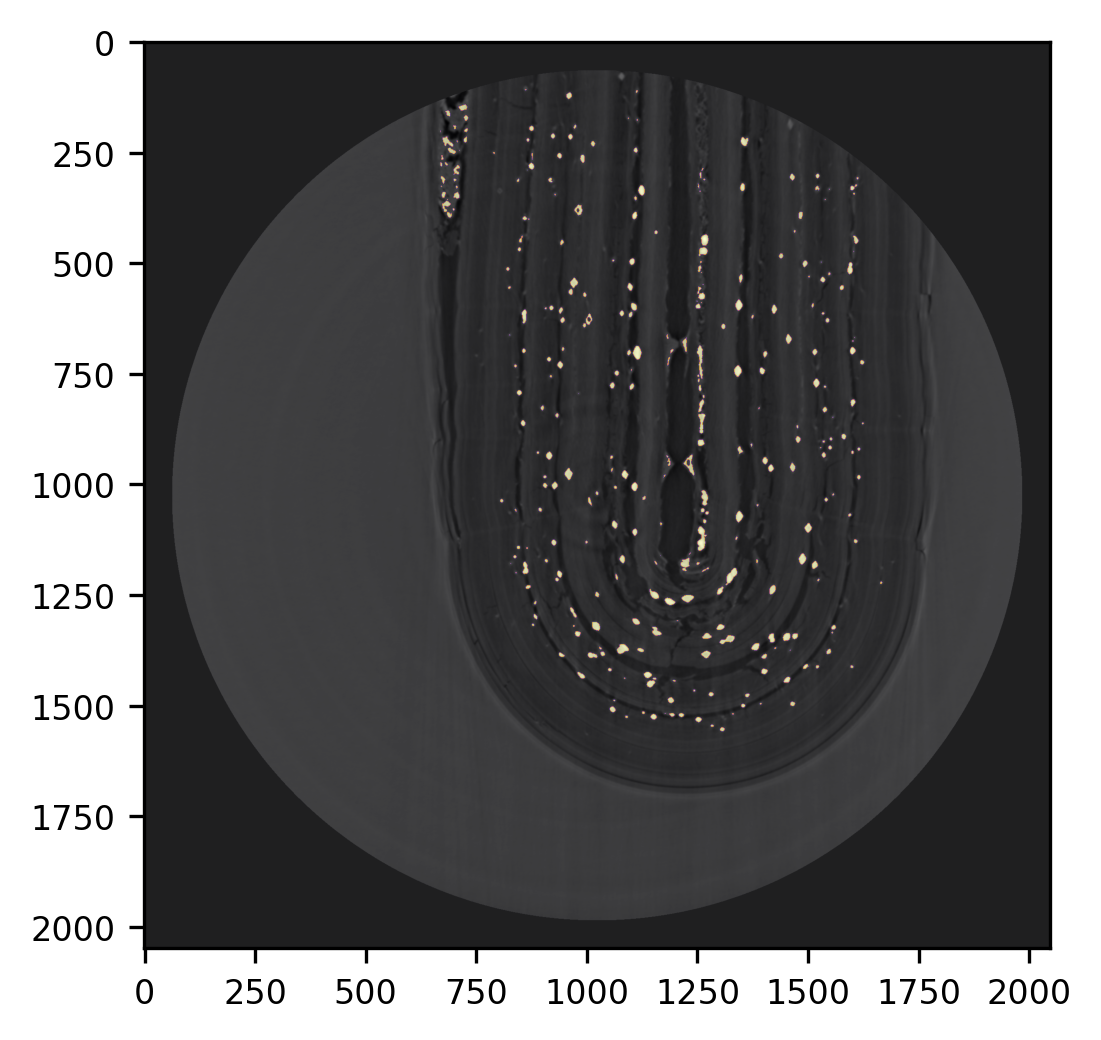

In [11]:
# Inspect slice
plt.imshow(data_3D[50,:,:], cmap='gray')
plt.imshow(BW_pearls[50,:,:], cmap='inferno', alpha=0.5)

## 1. Label single pearls
This time we use the `spam.label` toolkit instead of scikit's image labelling
**(update: takes ages and a lot of RAM compared with scikit)**

In [12]:
regions = spam.label.ITKwatershed.watershed(BW_pearls)

Label regions using `scikit`

In [9]:
regions_scikit = ndimage.label(BW_pearls)[0]

In [15]:
print("Particles identified by spam.ITKwatershed: {}".format(regions.max()))
print("Particles identified with scikit: {}".format(regions_scikit.max()))

Particles identified by spam.ITKwatershed: 2338
Particles identified with scikit: 2368


1.1. Write tiff stack of regions 

In [15]:
dxchange.write_tiff_stack(regions, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_labels/slice.tiff")

Inspect the result

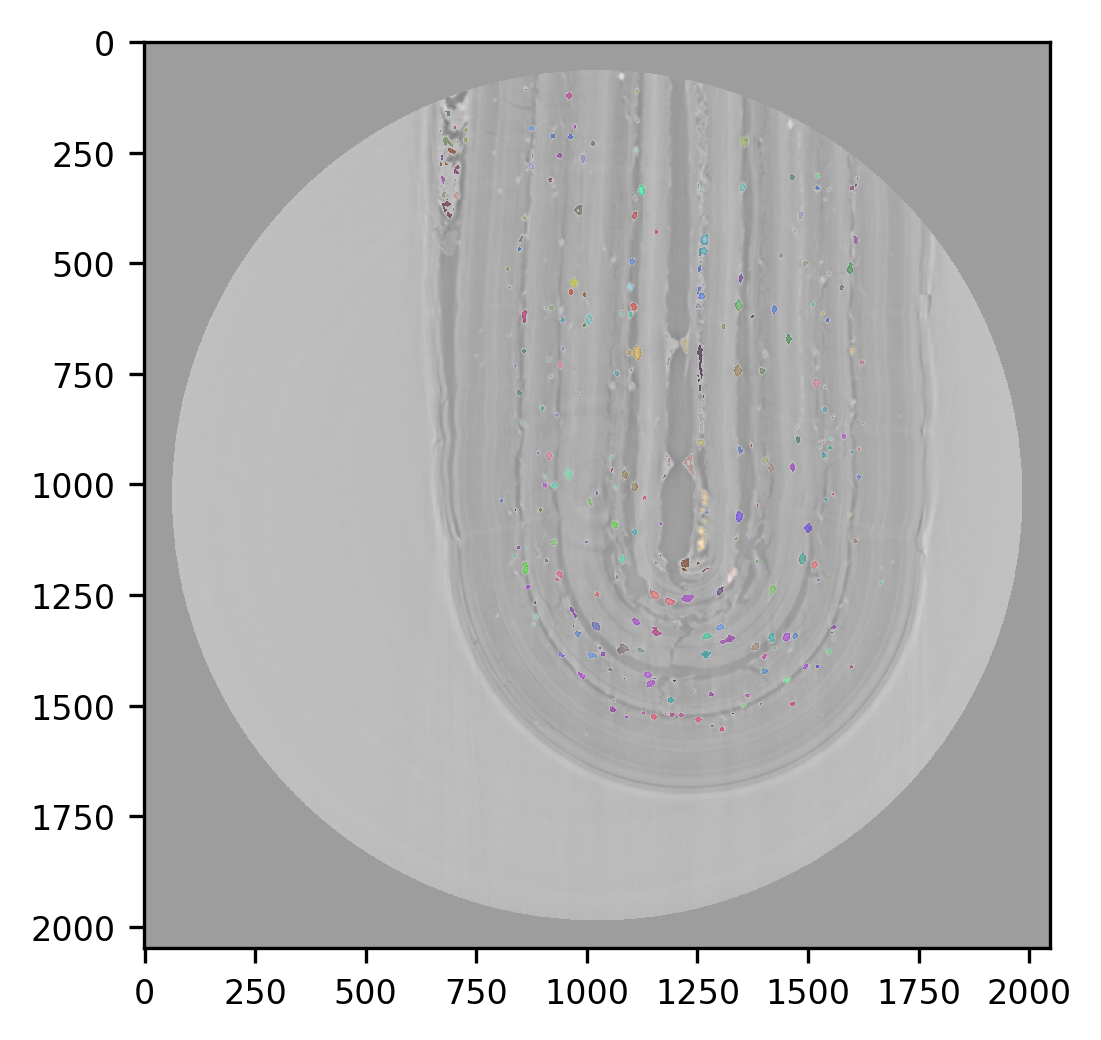

In [17]:
plt.imshow(data_3D[50,:,:], cmap='gray', interpolation='none')
# plt.imshow(labelled[midSlice], cmap=spam.label.randomCmap)
plt.imshow(regions_scikit[50,:,:], cmap=spam.label.randomCmap, alpha=0.5, interpolation='none') # 'tab20c'

`spam.ITKwatershed` performs better on clusters of particles not separated on the binary mask. For the purpose of this analysis `scikit`'s `region` method seems appropriate.

#### 1.2. Reload regions dataset
Only if you didn't run the previous section of this notebook

In [3]:
regions_scikit = read_tiff_stack("/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_labels/slice.tiff")

## 2. Volume of single pearls
Let’s compute the volumes of each particle and draw the distribution of particle volumes:

In [6]:
volumes = spam.label.volumes(regions)

Text(0, 0.5, 'count')

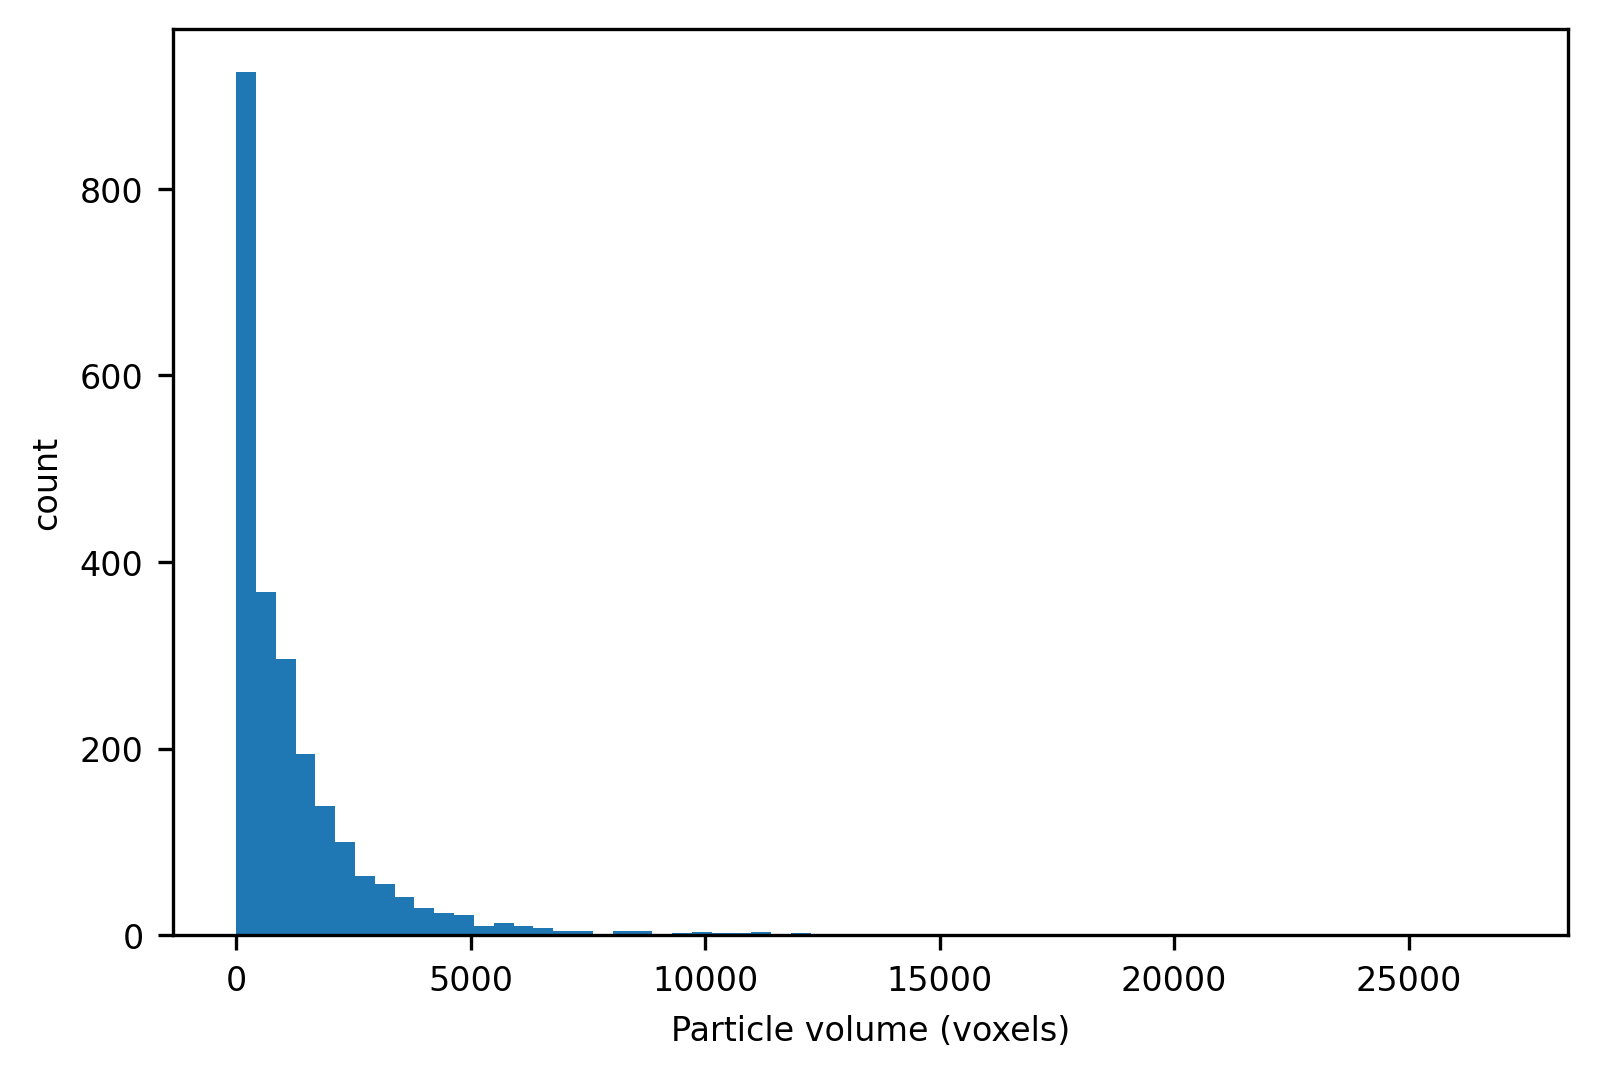

In [7]:
plt.figure()
plt.hist(volumes, bins=64)
plt.xlabel("Particle volume (voxels)")
plt.ylabel("count")

## 3. spam.label toolkit: Bounding Boxes
Bounding boxes are simply a description of the smallest box, aligned with Z Y X directions that each label can fit inside.

In [4]:
# boundingBoxes = spam.label.boundingBoxes(regions)
boundingBoxes = spam.label.boundingBoxes(regions_scikit)

## 4. spam.label toolkit: Centres of Mass
The centre of mass of each particle can also be computed with ease. The centresOfMass function can take as input the bounding boxes that we just computed in order to avoid re-computing them.
![centers of mass](100slices_regions_CentresOfMass.png)

In [5]:
# centresOfMass = spam.label.centresOfMass(regions, boundingBoxes=boundingBoxes)
centresOfMass = spam.label.centresOfMass(regions_scikit, boundingBoxes=boundingBoxes)

## 5. spam.label toolkit: True Sphericity
Calculates the degree of True Sphericity (psi) for all labels, as per: “Sphericity measures of sand grains” Rorato et al., Engineering Geology, 2019 and originlly proposed in: “Volume, shape, and roundness of rock particles”, Waddell, The Journal of Geology, 1932.

`True Sphericity (psi) = Surface area of equivalent sphere / Actual surface area`

In [59]:
sphericity = spam.label.trueSphericity(regions_scikit, boundingBoxes=boundingBoxes, centresOfMass=centresOfMass, gaussianFilterSigma=0, minVol=1200)

In [32]:
print(sphericity[sphericity<=1])

[0.    0.843 0.312 ... 0.876 0.969 0.862]


Text(0, 0.5, 'count')

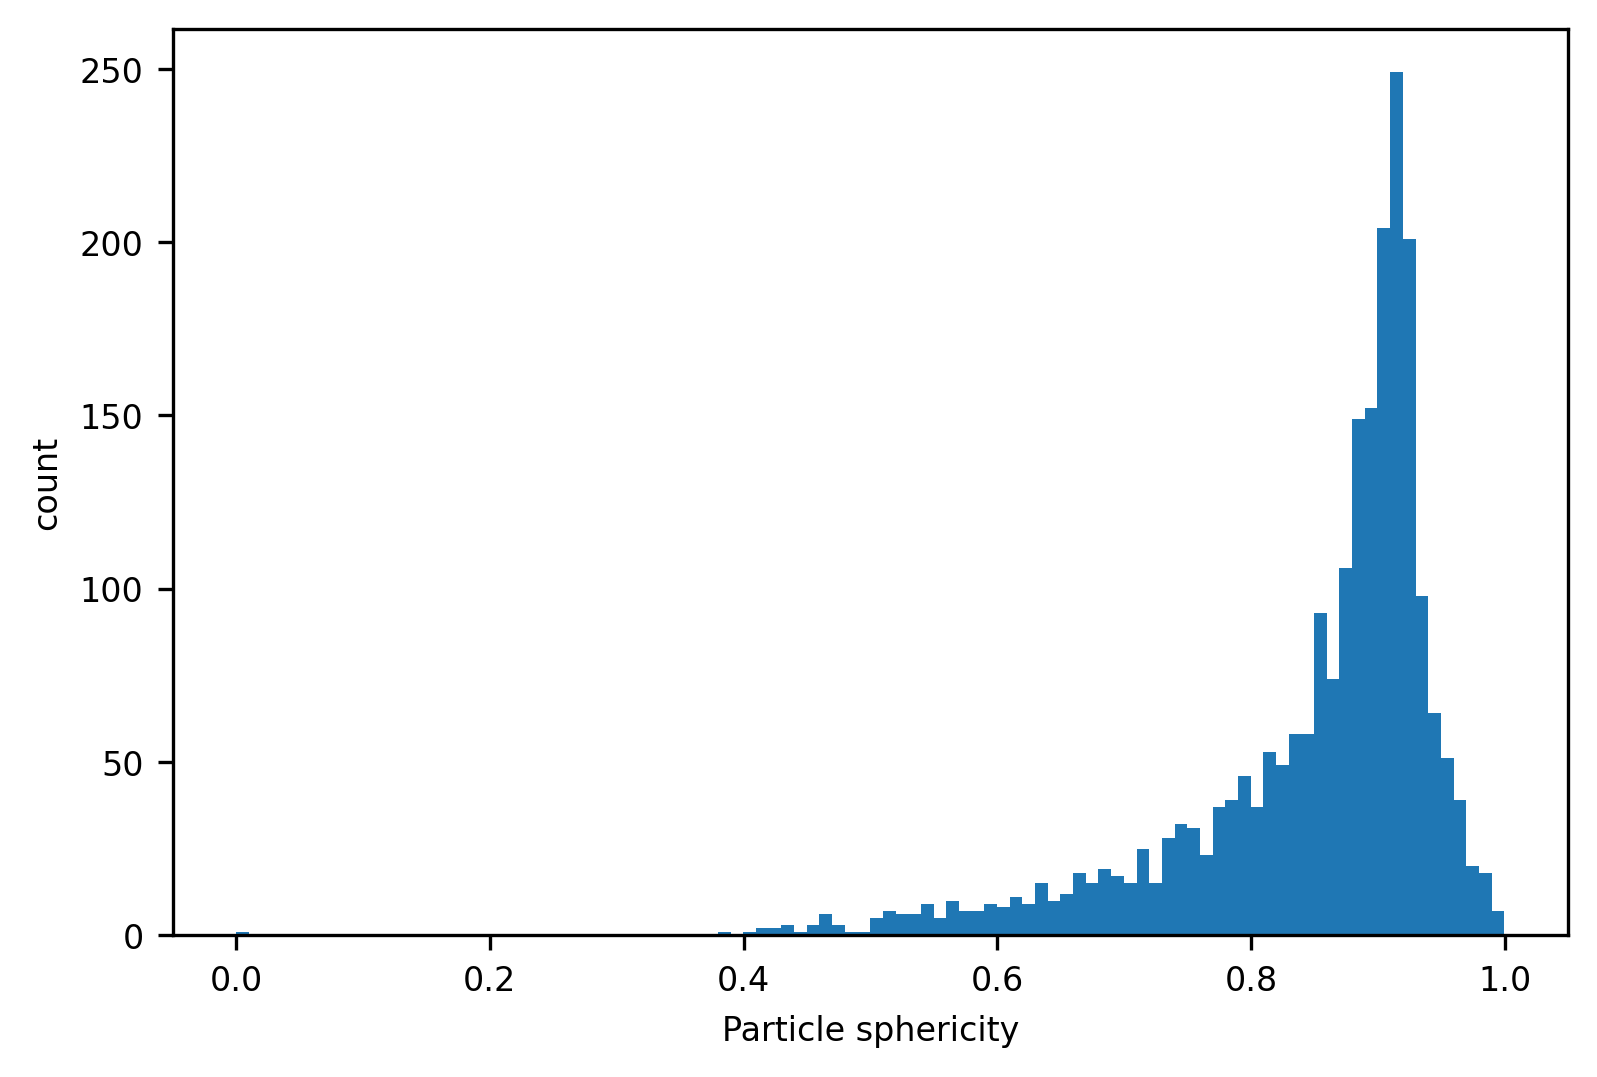

In [60]:
plt.figure()
plt.hist(sphericity[sphericity<=1], bins=100)
plt.xlabel("Particle sphericity")
plt.ylabel("count")

---
Test sphericity on known shape

In [20]:
from skimage import morphology

In [52]:
diamond = np.pad(morphology.octahedron(12), 1)

In [54]:
diamond[12,:,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

In [55]:
sphericity_diamond = spam.label.trueSphericity(diamond, gaussianFilterSigma=0, minVol=10)

In [56]:
sphericity_diamond

array([0.  , 0.85], dtype=float32)

## 6. spam.label toolkit: Moments of Inertia (particle orientation)

In [15]:
MOIeigenValues, MOIeigenVectors = spam.label.momentOfInertia(regions, boundingBoxes=boundingBoxes, centresOfMass=centresOfMass)

Try a plot of the particle orientation: display the 3D orientation of the long axes of each label.

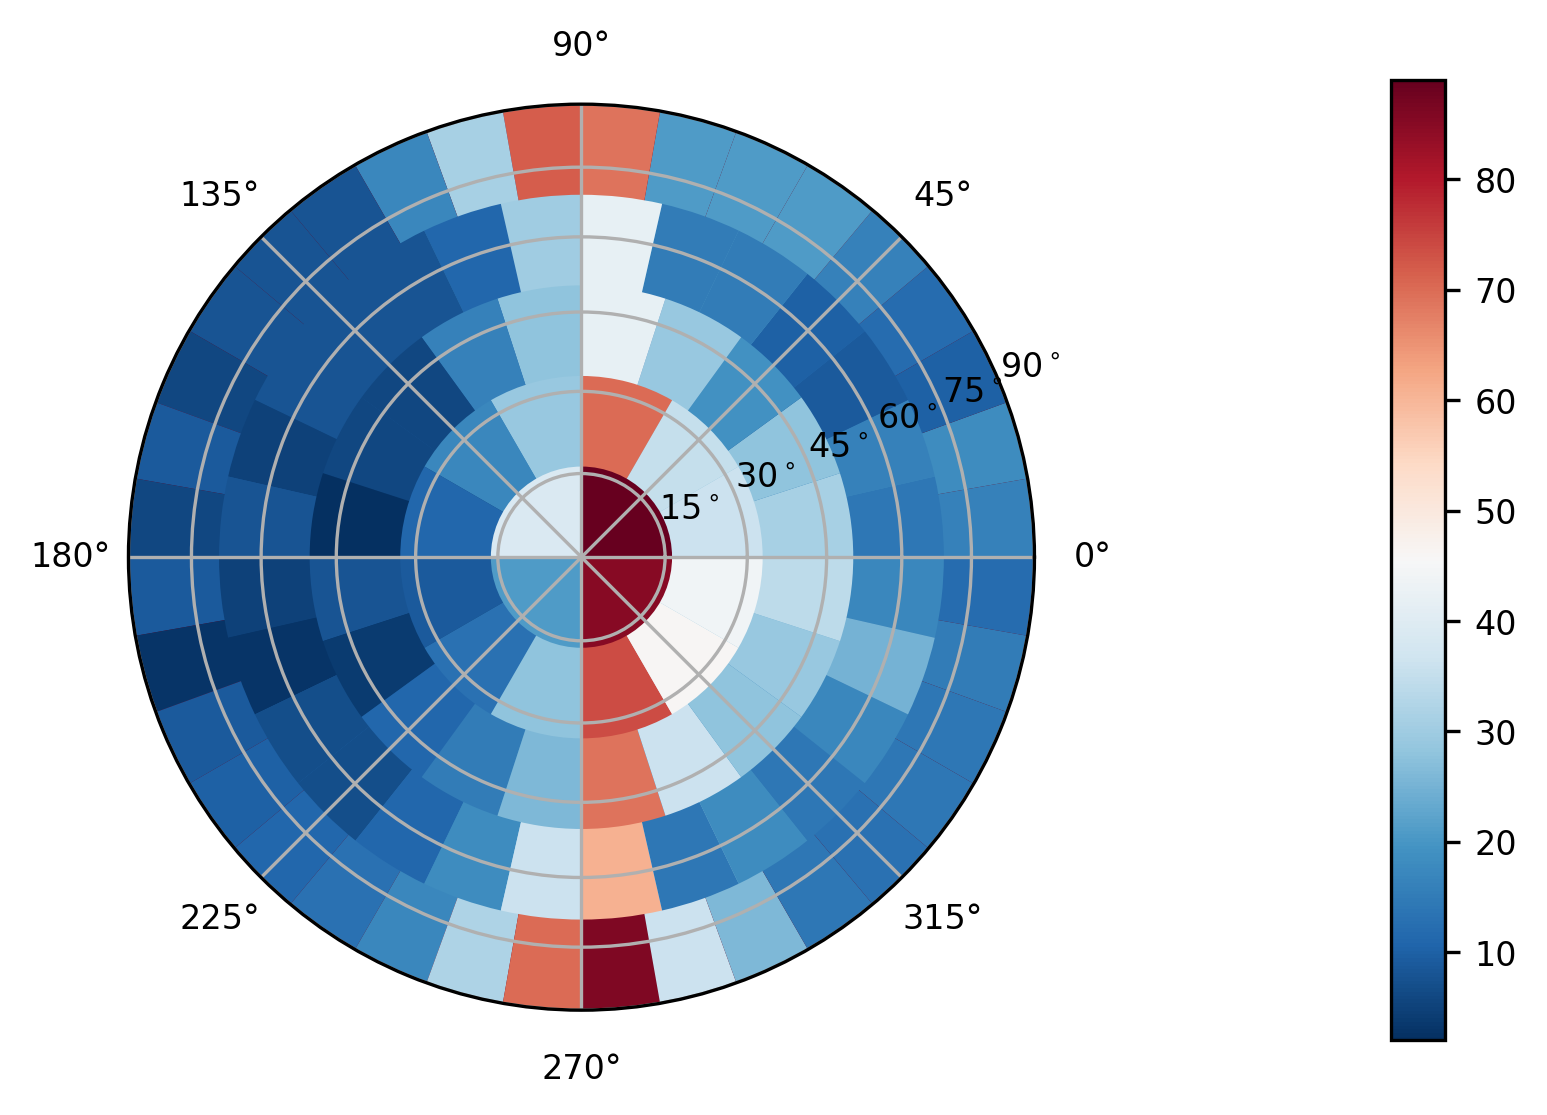

In [45]:
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[1:, 6:9], plot='bins', numberOfRings=5)

There is a strong alingment of the pearls along the Z-Y plane

## 7. spam.label toolkit: Ellipse Axes (radii of the ellipsoid fitting the particle)

In [26]:
ellipseDimensions = spam.label.ellipseAxes(regions, volumes=volumes, MOIeigenValues=MOIeigenValues)

#### 7.1. From the ellipse axes we can calculate an anysotropy factor as the ratio between short and long axes
`DA = short_radius / large_radius`

In [27]:
# Degree of Anisotropy
DA = ellipseDimensions[1:, 2] / ellipseDimensions[1:, 0]

## 8. spam.label toolkit: Particle Size Distribution
#### 8.1. Compute the equivalent-volume-sphere radii for each pearl

In [48]:
equivalentRadii = spam.label.equivalentRadii(regions, boundingBoxes=boundingBoxes)

#### 8.2.  Plot comparison of the equivalent-volume-sphere radii with the distribution of largest and smallest ellipsoid axes as calculated above

	plotParticleSizeDistribution(): Multiplying radii by two to make diameters
	plotParticleSizeDistribution(): Multiplying radii by two to make diameters
	plotParticleSizeDistribution(): Multiplying radii by two to make diameters


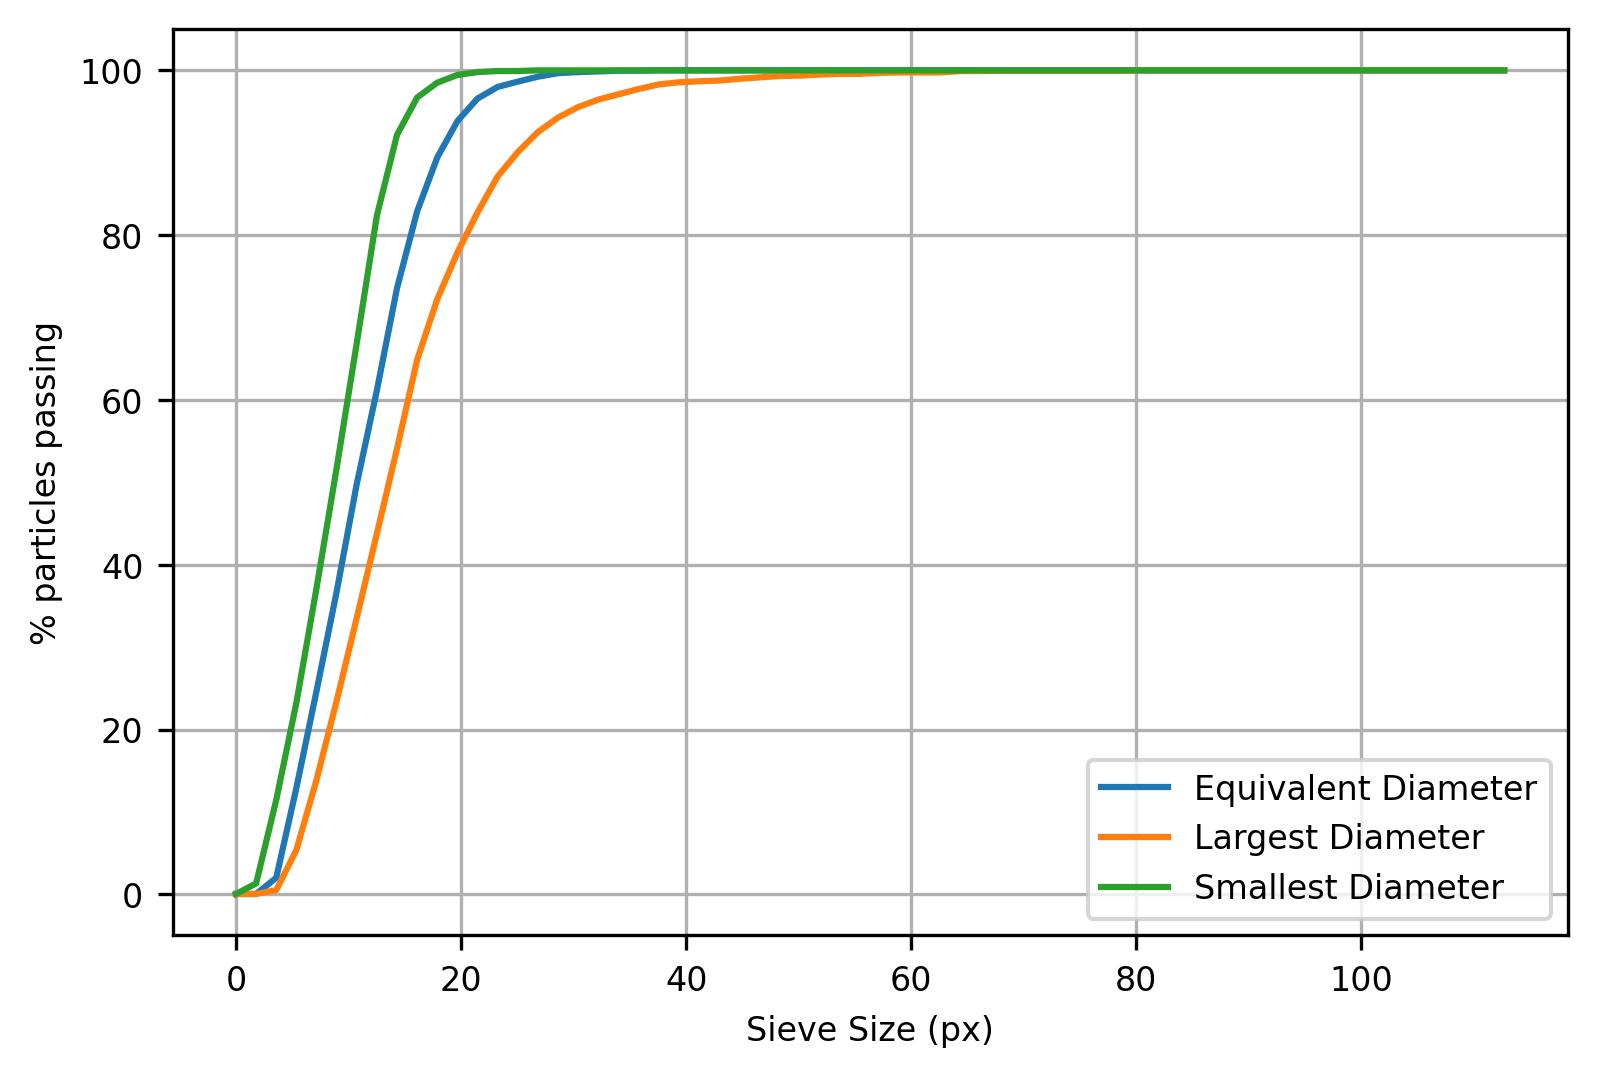

In [49]:
# Run the particle size distribution plotter
spam.plotting.plotParticleSizeDistribution([equivalentRadii.tolist(),
                                         ellipseDimensions[:, 0].tolist(),
                                         ellipseDimensions[:, 2].tolist()], bins=64,
                                         legendNames=["Equivalent Diameter", "Largest Diameter", "Smallest Diameter"],
                                         cumulative=True)

## 9. spam.label toolkit: showing scalars using labels
Store label image colored with the particle sphericity

In [52]:
regions_sphericity = spam.label.convertLabelToFloat(regions, sphericity)

Store label image colored with the particle volume

In [8]:
regions_volume = spam.label.convertLabelToFloat(regions, volumes)

In [9]:
# dxchange.write_tiff_stack(regions_sphericity, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_sphericity/slice.tiff")
dxchange.write_tiff_stack(regions_volume, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_regions_volume/slice.tiff")

## 10. visualize particle orientation in paraview
![pearls orientation](100slices_regions_orientation.png)
Generate table of the particle centroids and first eigenvector components.

#### 10.1. Save point set and vector data as unstructured grid `VTK`
To do:
- [ ] add DA scalar field
- [ ] add ellipse radii vector field
- [ ] display in Paraview scaling and coloring by DA
- [ ] display in Paraview coloring by orientation angle
    - see [`spam.plotting.orientationPlotter`](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_modules/plotting/orientationPlotter.html#plotOrientations) and [`orientations.analyse.fitVonMisesFisher`](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/orientations.html#module-orientations.analyse) or `orientations.analyse.projectOrientation`

In [33]:
import meshio

In [34]:
centresOfMass[1:, [2, 1, 0]]

array([[ 966.351,  107.468,    2.863],
       [ 724.724,  144.677,    3.025],
       [ 703.023,  144.977,    0.605],
       ...,
       [1184.636, 1512.318,   97.727],
       [1207.721, 1536.698,   97.558],
       [1112.846, 1544.769,   97.615]], dtype=float32)

In [40]:
meshio.write_points_cells("foo.vtk", centresOfMass[1:, [2, 1, 0]], [], point_data={"Orientation": MOIeigenVectors[1:, [8, 7, 6]]})

## 11. Particle distance from pit bottom
11.1. Load mask of the pit bottom

In [10]:
mask_file = "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_pit_bottom/slice_0000.tiff"

In [11]:
BW_pit_bottom = read_tiff_stack(mask_file)

11.2. Distance transform from the pit bottom

In [ ]:
dist = ndimage.distance_transform_edt(~BW_pit_bottom)

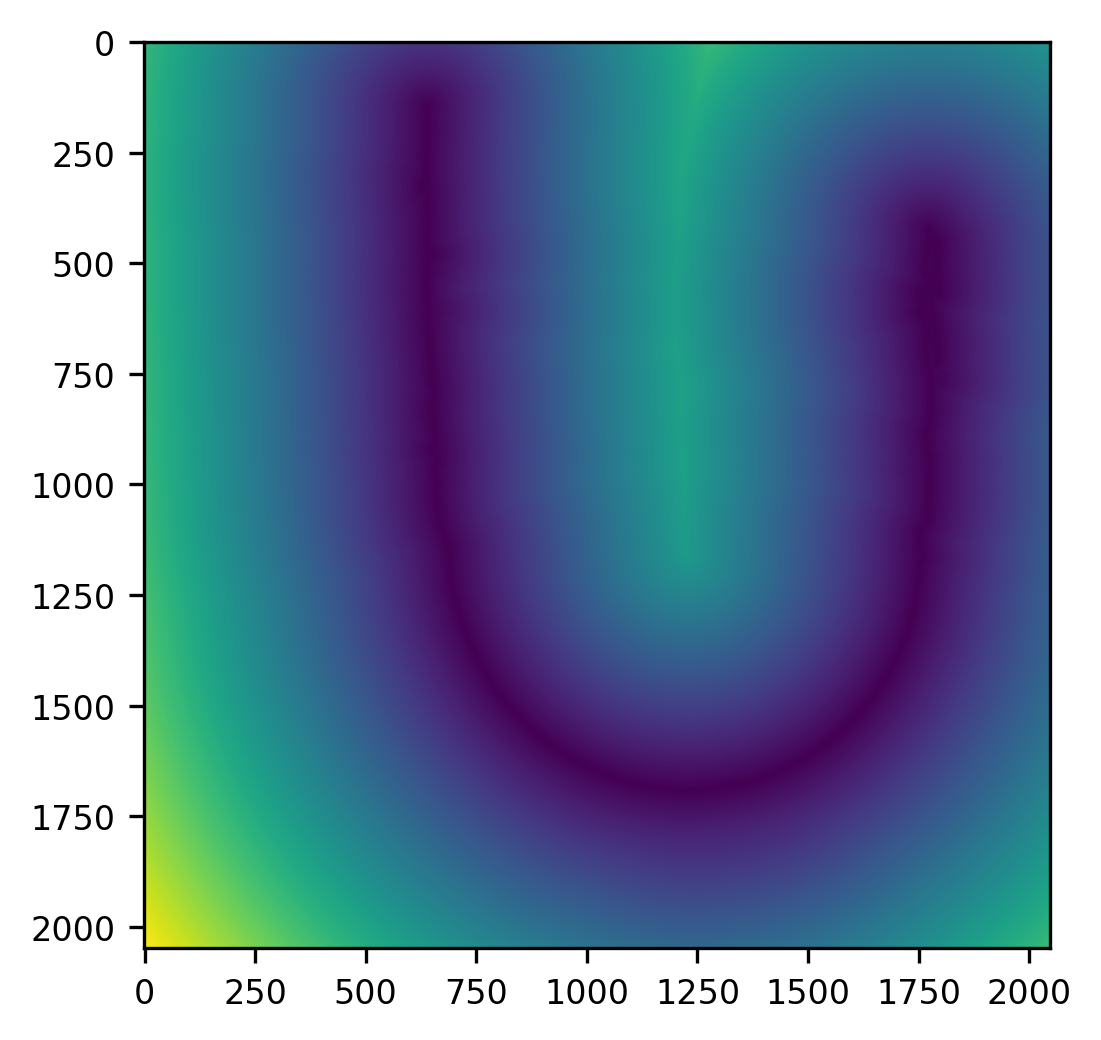

In [14]:
plt.imshow(dist[20,:,:])

11.3. Save distance transform for the future

In [17]:
dxchange.write_tiff_stack(dist, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_dist_pit_bottom/slice.tiff")

11.3.1. Reload it

In [12]:
dist_file = "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_dist_pit_bottom/slice_0000.tiff"

In [13]:
dist = read_tiff_stack(dist_file)

#### 11.4. Find dist at each center of mass

In [18]:
COM_coors = np.round(centresOfMass).astype(int)

In [19]:
distances_pit_bottom = np.ndarray(volumes.shape)
count = 0
for COM in COM_coors:
    distances_pit_bottom[count] = dist[COM[0], COM[1], COM[2]]
    count = count + 1

In [20]:
distances_pit_bottom.shape

(2339,)

#### 11.5. Histogram of the particle distance from pit bottom

Text(0, 0.5, 'count')

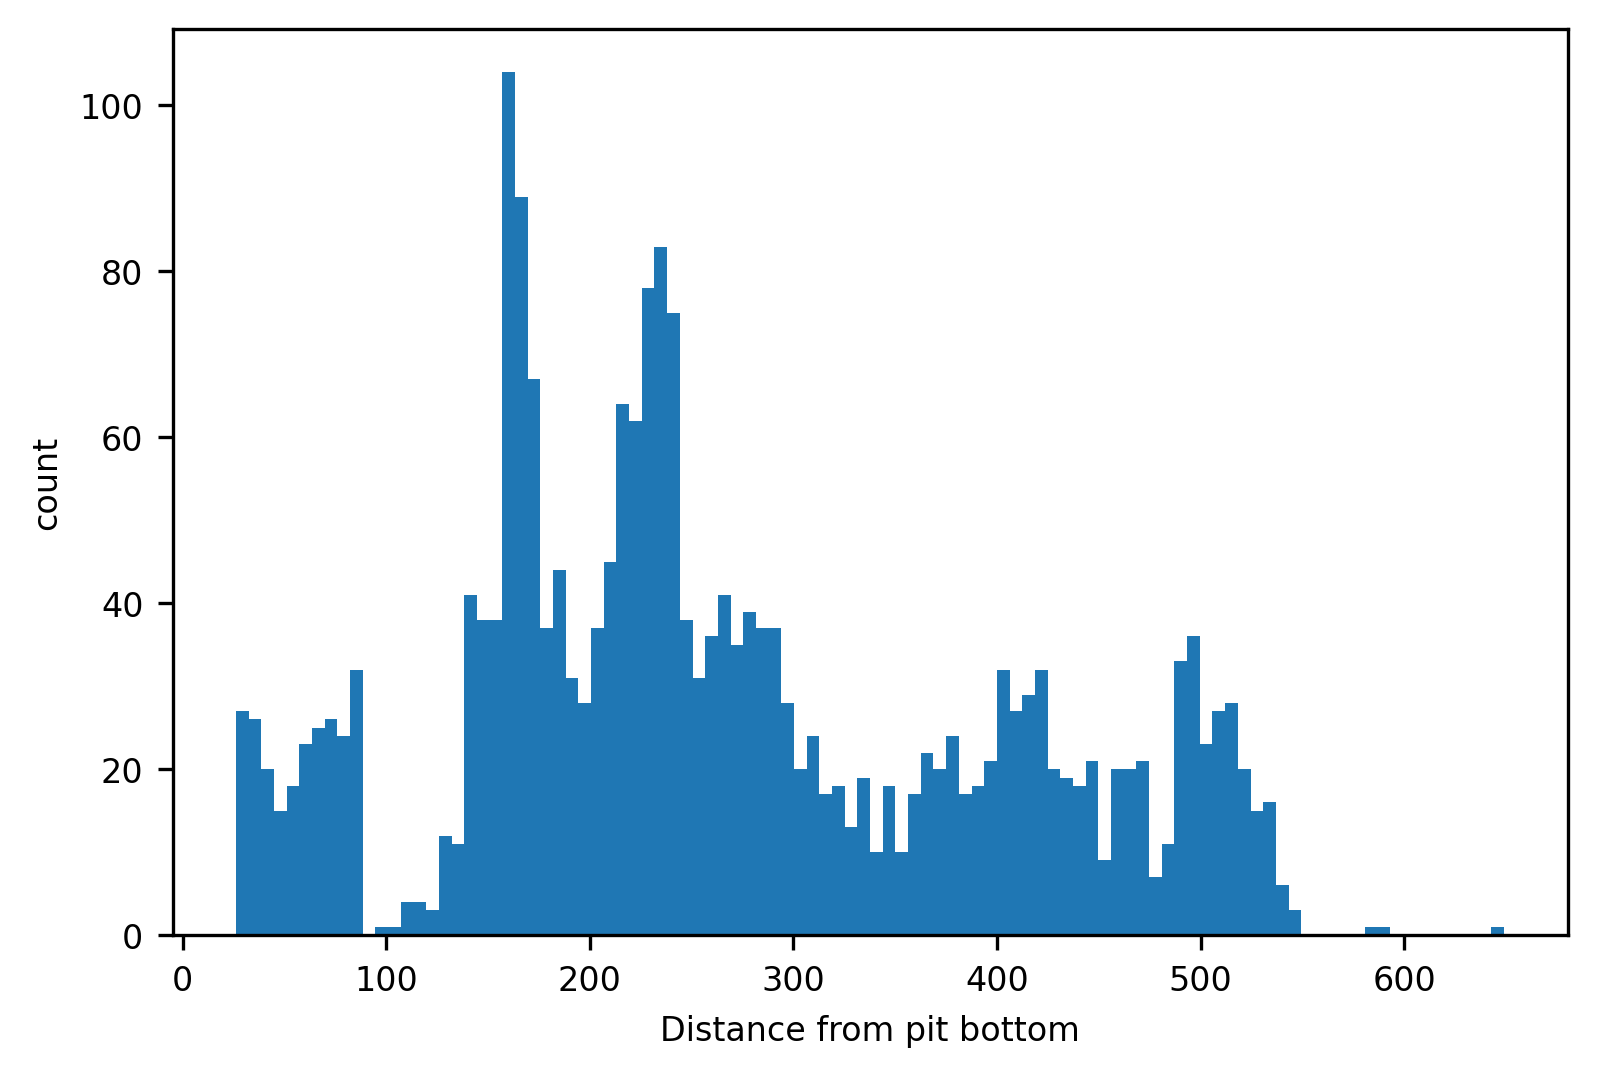

In [63]:
plt.figure()
plt.hist(distances_pit_bottom, bins=100)
plt.xlabel("Distance from pit bottom")
plt.ylabel("count")

### 11.6. Relation particle depth - particle size (or sphericity)

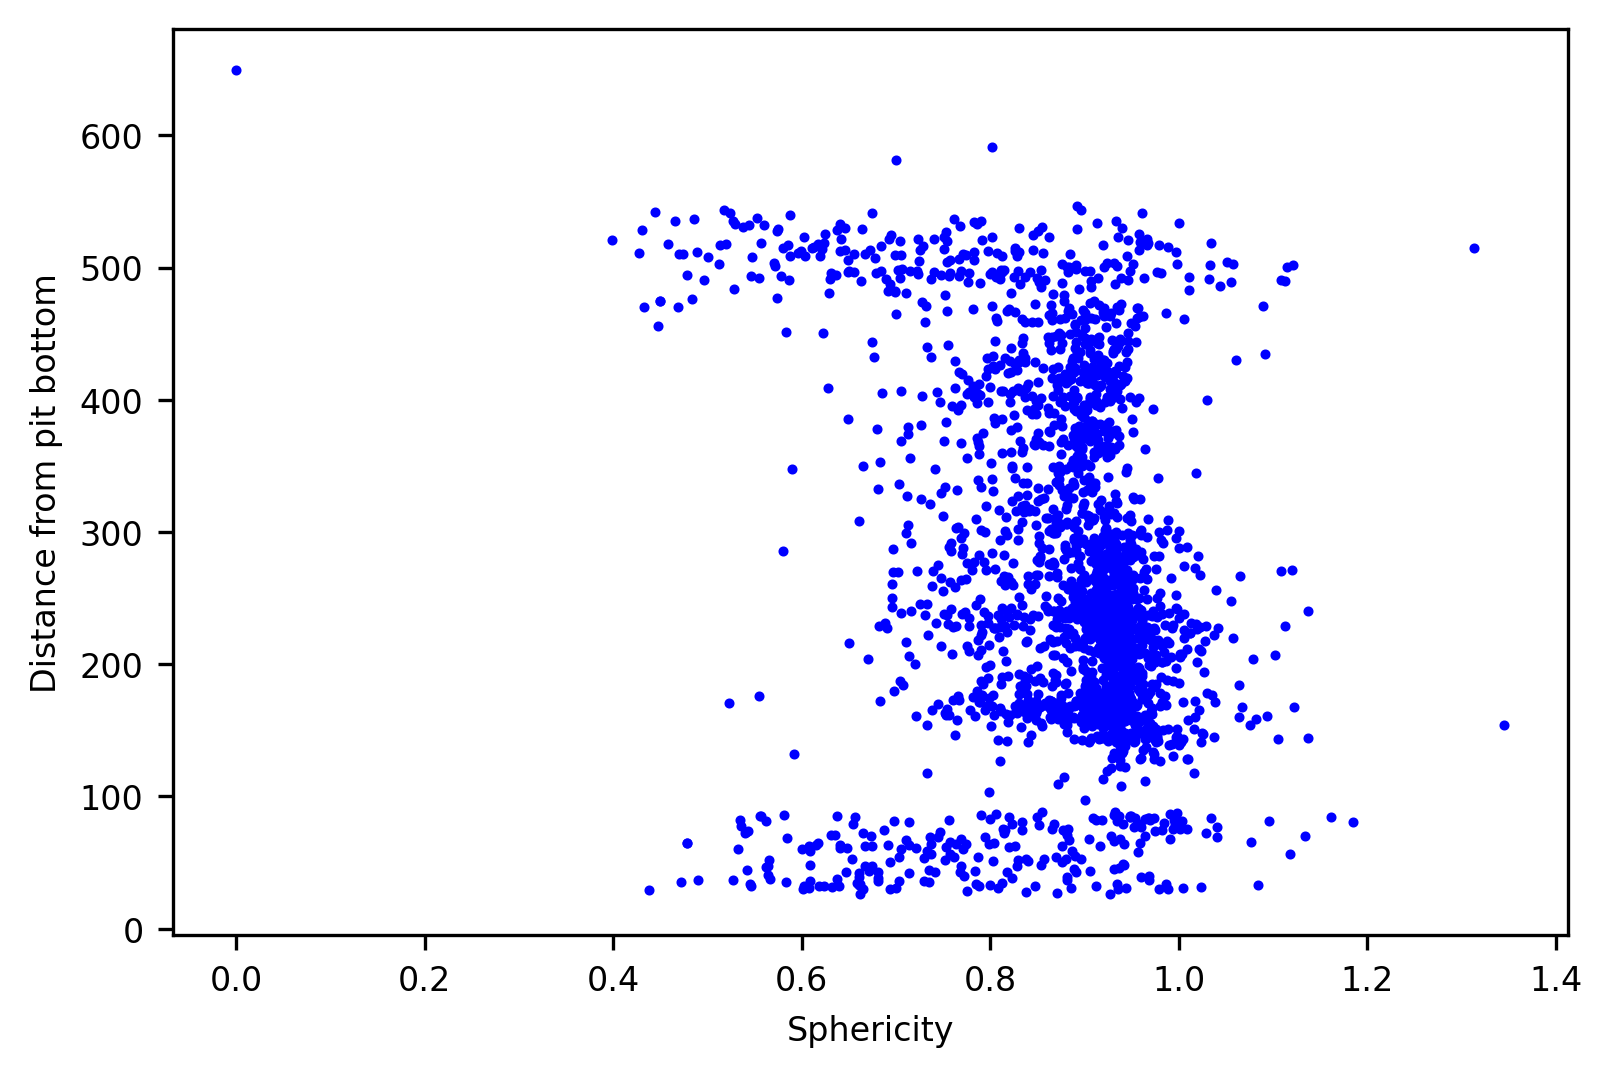

In [66]:
plt.scatter(sphericity, distances_pit_bottom, s=2, c="b")
plt.ylabel("Distance from pit bottom")
plt.xlabel("Sphericity")
plt.show()

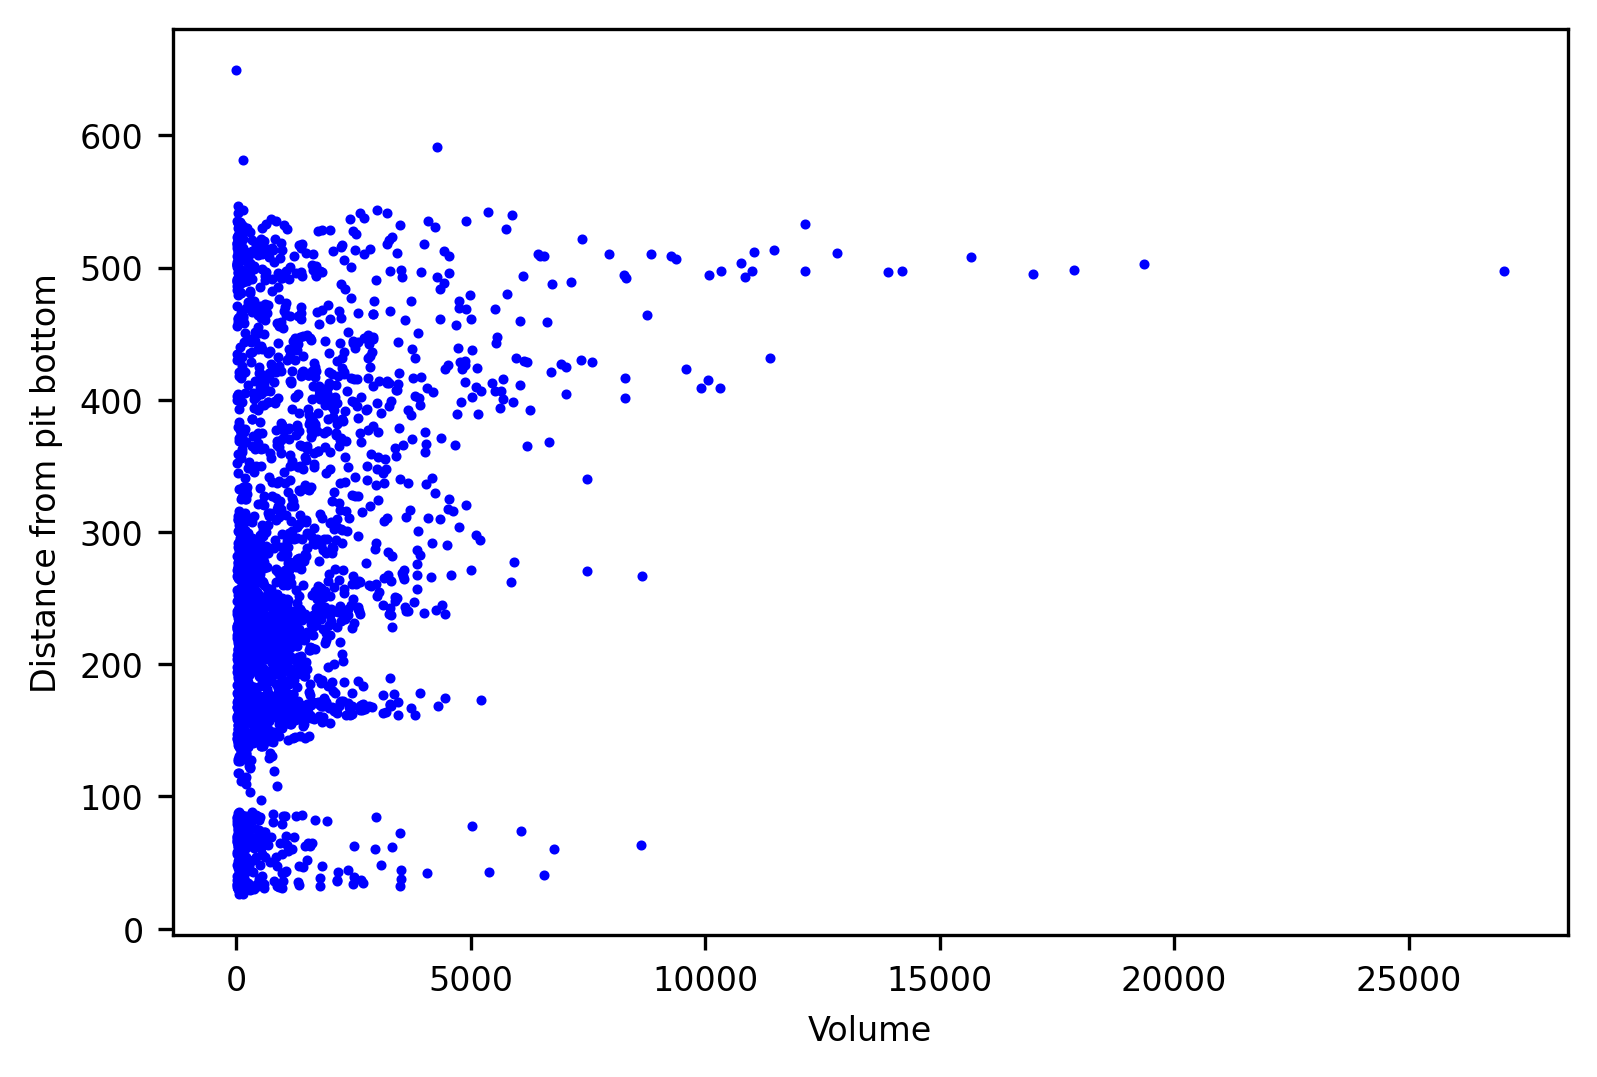

In [67]:
plt.scatter(volumes, distances_pit_bottom, s=2, c="b")
plt.ylabel("Distance from pit bottom")
plt.xlabel("Volume")
plt.show()

#### 11.7. Show scalars using labels
Store label image colored with the particle distance from pit bottom

In [21]:
regions_pit_dist = spam.label.convertLabelToFloat(regions, distances_pit_bottom)

In [22]:
dxchange.write_tiff_stack(regions_pit_dist, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_regions_dist_pit_bottom/slice.tiff")